In [1]:
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

from rsq import AgglomerativeEnsemble
from rsq.helpers import stratified_sample, few_shot_sample

import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons
from sklearn.neighbors import KNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading

def exp(n_unlabeled=100, n_labeled_per_class=1, noise=0.1, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    accuracies = np.zeros(6)
    
    n_labeled=2*n_labeled_per_class
    
    X, y = make_moons(10000, noise=noise)
    perm = np.random.choice(10000, 10000, replace=False)

    X_labeled_1 = X[perm][np.where(y[perm] == 0)[0][:n_labeled_per_class]]
    X_labeled_2 = X[perm][np.where(y[perm] == 1)[0][:n_labeled_per_class]]
    X_labeled = np.concatenate((X_labeled_1, X_labeled_2), axis=0)
    
    del X, y
    
    y_labeled = np.concatenate((np.zeros(n_labeled_per_class), np.ones(n_labeled_per_class)))
    
    X, y = make_moons(10000, noise=noise)
    X_unlabeled = X[:n_unlabeled]
    y_unlabeled = y[:n_unlabeled]
        
    X_test, y_test = make_moons(1000, noise=noise)
    
    clf=SVC()
    clf.fit(X_labeled, y_labeled)
    y_hat=clf.predict(X_test)
    accuracies[1] = (y_test == y_hat).mean()
    
    
    clf=DecisionTreeClassifier()
    clf.fit(X_labeled, y_labeled)
    y_hat=clf.predict(X_test)
    accuracies[2] = (y_test == y_hat).mean()
    
    
    clf=KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    clf.fit(X_labeled, y_labeled)
    y_hat=clf.predict(X_test)
    accuracies[3] = (y_test == y_hat).mean()

    
    y_ = -1 * np.ones(n_labeled + n_unlabeled)
    y_[:n_labeled] = y_labeled.copy()

    n_neighbors = max([1, int(np.math.floor(np.log(len(y_))))])
    clf=AgglomerativeEnsemble(n_estimators=1, p_inbag=1, affinity='euclidean', linkage='single', n_neighbors=1, gem_p=128)
    clf.fit(np.concatenate((X_labeled, X_unlabeled), axis=0), y_)
    y_hat=clf.predict(X_test)
    accuracies[0] = (y_test == y_hat).mean()
    
    clf=LabelPropagation(n_neighbors=1)
    clf.fit(np.concatenate((X_labeled, X_unlabeled), axis=0), y_)
    y_hat=clf.predict(X_test)
    accuracies[4] = (y_test == y_hat).mean()
    
    clf=LabelSpreading(n_neighbors=1)
    clf.fit(np.concatenate((X_labeled, X_unlabeled), axis=0), y_)
    y_hat=clf.predict(X_test)
    accuracies[5] = (y_test == y_hat).mean()
    
        
    print(accuracies)

    return accuracies

In [17]:
n_labeled=1
n_labeled_list = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 5000])
condensed_func = lambda x: exp(x, n_labeled, 0.01)

n_mc=180
n_cores=90

algos = ['AggClass', 'SVM (linear)', 'Decision Tree', '1-NN', 'Label Propagation', 'Label Spreading']

func_tuples = []
for n_labeled_ in n_labeled_list:
    for i in range(n_mc):
        func_tuples.append(n_labeled_)
        
accuracies_list = Parallel(n_jobs=90)(delayed(condensed_func)(x) for x in func_tuples)

In [18]:
accuracies=np.zeros((len(algos), len(n_labeled_list), n_mc))

for i in range(len(n_labeled_list)):
    for j in range(n_mc):
        accuracies[0, i, j] = accuracies_list[int(i*n_mc + j)][0]
        accuracies[1, i, j] = accuracies_list[int(i*n_mc + j)][1]
        accuracies[2, i, j] = accuracies_list[int(i*n_mc + j)][2]
        accuracies[3, i, j] = accuracies_list[int(i*n_mc + j)][3]
        accuracies[4, i, j] = accuracies_list[int(i*n_mc + j)][4]
        accuracies[5, i, j] = accuracies_list[int(i*n_mc + j)][5]

0.97
0.25


NameError: name 'RandomForestClassifier' is not defined

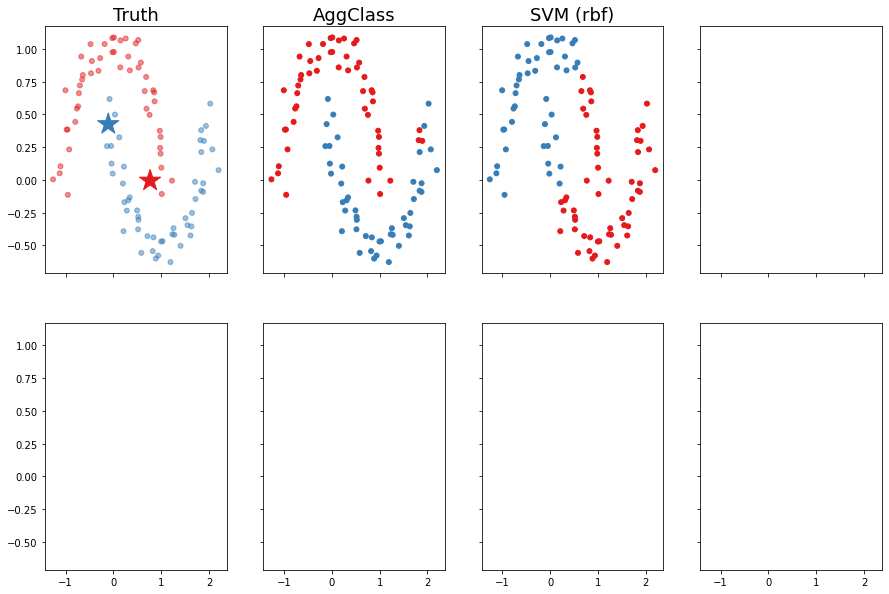

In [19]:
fig, ax = plt.subplots(2,4, figsize=(15,10), sharex=True, sharey=True)
n_labeled=2

colors=sns.color_palette("Set1", n_colors=len(algos)+5)

fontsize=18
n_labeled_per_class=1

n_labeled=2*n_labeled_per_class
n_unlabeled=98
    
at_least_n_labeled_per_class = False
while not at_least_n_labeled_per_class:
    X_labeled, y_labeled = make_moons(n_labeled, noise=0.15)

    if len(np.where(y_labeled == 1)[0]) >= n_labeled_per_class and len(np.where(y_labeled == 0)[0]) >= n_labeled_per_class:
        at_least_n_labeled_per_class=True

X_unlabeled, y_unlabeled = make_moons(n_unlabeled, noise=0.1)
X = np.concatenate((X_labeled, X_unlabeled), axis=0)
y = np.concatenate((y_labeled, y_unlabeled))

y_ = -1 * np.ones(n_labeled + n_unlabeled)
y_[:n_labeled] = y_labeled.copy()
        
s=25
        
ax[0,0].scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c=np.array(colors)[np.array([0,1])][y_unlabeled.astype(int)], s=s, alpha=0.5)
ax[0,0].scatter(X_labeled[:, 0], X_labeled[:, 1], c=np.array(colors)[np.array([0,1])][y_labeled.astype(int)], marker='*', s=500)
ax[0,0].set_title('Truth', fontsize=fontsize)

clf=AgglomerativeEnsemble(n_estimators=1, p_inbag=1, affinity='euclidean', linkage='single', 
                          n_neighbors=1, gem_p=32, classes=np.array([0,1]))
clf.fit(X, y_)
y_hat=clf.predict(X)
print((y_hat == y).mean())
ax[0,1].scatter(X[:, 0], X[:, 1], c=np.array(colors)[np.array([0,1])][y_hat.astype(int)], s=s)
ax[0,1].set_title('AggClass', fontsize=fontsize)

clf=SVC()
clf.fit(X_labeled, y_labeled)
y_hat=clf.predict(X)
print((y_hat == y).mean())
ax[0,2].scatter(X[:, 0], X[:, 1], c=np.array(colors)[np.array([0,1])][y_hat.astype(int)], s=s)
ax[0,2].set_title('SVM (rbf)', fontsize=fontsize)

clf=RandomForestClassifier()
clf.fit(X_labeled, y_labeled)
y_hat=clf.predict(X)
print((y_hat == y).mean())
ax[0,3].scatter(X[:, 0], X[:, 1], c=np.array(colors)[np.array([0,1])][y_hat.astype(int)], s=s)
ax[0,3].set_title('Decision Tree', fontsize=fontsize)


clf=KNeighborsClassifier(n_neighbors=1)
clf.fit(X_labeled, y_labeled)
y_hat=clf.predict(X)
print((y_hat == y).mean())
ax[1,0].scatter(X[:, 0], X[:, 1], c=np.array(colors)[np.array([0,1])][y_hat.astype(int)], s=s)
ax[1,0].set_title('1-NN', fontsize=fontsize)





clf=LabelPropagation(kernel='rbf',n_neighbors=5)
clf.fit(X, y_)
y_hat=clf.predict(X)
print((y_hat == y).mean())
ax[1,1].scatter(X[:, 0], X[:, 1], c=np.array(colors)[np.array([0,1])][y_hat.astype(int)], s=s)
ax[1,1].set_title('Label Propagation', fontsize=fontsize)




clf=LabelSpreading(kernel='rbf', n_neighbors=5)
clf.fit(X, y_)
y_hat=clf.predict(X)
print((y_hat == y).mean())
ax[1,2].scatter(X[:, 0], X[:, 1], c=np.array(colors)[np.array([0,1])][y_hat.astype(int)], s=s)
ax[1,2].set_title('Label Spreading', fontsize=fontsize)





ax[1,3].set_title('Isomap + 1-NN', fontsize=fontsize)











for ax__ in ax:
    for ax_ in ax__:
        ax_.set_yticks([])
        ax_.set_xticks([])


plt.tight_layout()

In [ ]:
class IsomapClassifier:
    def __init__(self, metric='euclidean',
                n_neighbors=1,
                classes=None):

        self.metric=metric
        self.n_neighbors = n_neighbors
                
        self.classes_ = classes

        
    def fit(self, X, y):
        self.n, d = X.shape

        self.labeled_inds = np.where(y != -1)[0]
                
        if self.classes_ is None:
            self.classes_ = np.unique(y[self.labeled_inds])
            
        if -1 in self.classes_:
            self.classes_ = self.classes_[1:]
                        
        self.model = Isomap(metric=self.metric, n_neighbors=self.n_neighbors)
        self.model.fit(X)
                    
        self.nn = NearestNeighbors(n_neighbors=self.n_neighbors, metric=self.metric)
        self.nn.fit(X)
        
        labeled_inds_by_class = [np.where(y[self.labeled_inds] == c)[0] for c in self.classes_]
        decision_paths, counts = get_decision_paths(self.n, self.model.children_)
        
        self._get_tree_distances(decision_paths, counts)        
        self._get_similarities_to_classes(labeled_inds_by_class)
        
                                    
                
    def predict_proba(self, X):
        _, neighbor_inds = self.nn.kneighbors(X)
        scores = np.mean(self.similarities_to_classes[neighbor_inds], axis=1)
        return softmax(scores, axis=1)
    
    
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]



In [ ]:
fig, ax = plt.subplots(1,1)

ax.set_xscale('log')
for i, algo in enumerate(algos):
    if i >= 5:
        ci = i+1
    else:
        ci = i
    ax.scatter(n_labeled_list, np.mean(accuracies, axis=-1)[i], color=colors[ci], label=algo)
    ax.errorbar(n_labeled_list, np.mean(accuracies, axis=-1)[i], color=colors[ci], yerr=np.std(accuracies, axis=-1)[i] / np.sqrt(n_mc))

#     for j, n_labeled in enumerate(n_labeled_list):
#         if j > 0:
#             continue
#         ax.scatter([n_labeled + (i-1)/2.5]*n_mc, accuracies[i, j], color=colors[i], s=1, alpha=1)
    
    
ax.legend()
ax.set_xlabel('# unlabeled samples')
ax.set_title('Accuracy vs # unlabeled samples')


    
# ax.set_yticks([0.7,0.8,0.9,1])
ax.set_xticks([1, 10, 100, 1000])

In [ ]:
accuracies